In [17]:
# load custom library

import sys
sys.path.append('../')
from importlib import reload
from modules import my_functions as mf
reload(mf)

# exploring data

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# scikit-learn libraries

from sklearn import set_config
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay

# models

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from xgboost import XGBClassifier

# optimimization

import gc
import time
from contextlib import contextmanager



In [2]:
@contextmanager
def timer(name):
    """Decorator that print the elapsed time and argument."""
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

# Etape 4 : Simulez et comparez plusieurs modèles :

## 4.1 - Stratégie de modélisation :

1. Import des datasets
2.  Réalisation d'un pipeline de `preprocessing` :
       * Imputation des `NaN` en testant plusieurs solutions : '0', 'mean', 'median'
       * standardisation
3. Préparation de la metric `business_score` en passant par `make_scorer` afin de pouvoir l'utiliser dans les modèles
2. Entrainement d'un modèle : `LogisticRegression` pour une baseline (modèle robuste, simple et rapide à entrainer)
3. Entrainement et optimisation d'un modèle : `RandomForestClassifier` (modèle performant)  
5. Entrainement et optimisation d'un modèle Gradient Boosting : `LightGBM`
6. Entrainement et optimisation d'un modèle Gradient Boosting : `XGBoost`

**Optimisation et suivi :**
* Cross validation avec KFold et essais avec Startified KFold 
* Choix des hyperparamètres à optimiser dans GridSearchCV
* Suivi versioning avec Git et transféré sur GitHub : [Lien vers GitHub](https://github.com/jeromelegal/Projet_07)
* Suivi des expériences dans MLFlow : [Le lien pour accéder à MLFlow UI](http://192.168.2.189:8080/)

**Evaluation des modèles :**
* Score Accuracy
* Matrice de confusion
* Score Business_score
* Score AUC
* Courbe ROC

---
### 4.1.1 - Import et préparation des datasets :

In [3]:
train = pd.read_csv('../data/cleaned/train_V3.csv')
#test = pd.read_csv('../data/cleaned/test_V3.csv')

In [4]:
X_train_full = train.drop(columns=['TARGET'])
y_train_full = train['TARGET']
#X_test = test

Séparation du dataset `train` en `X_train` et `X_val` :

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)
del X_train_full, y_train_full
gc.collect()

40

In [6]:
print(f"X_train shape : {X_train.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"X_val shape : {X_val.shape}")
print(f"y_val shape : {y_val.shape}")

X_train shape : (230630, 695)
y_train shape : (230630,)
X_val shape : (76877, 695)
y_val shape : (76877,)


Préparation d'une fonction pour réaliser un KFold ou un StratifiedKFold lors de l'entrainement : 

In [7]:
def folds(type_kfold='KFold'):
    """choose KFold or StratifiedKFold"""
    if type_kfold == 'KFold':
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
    elif type_kfold == 'StratifiedKFold':
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    else:
        print("Wich type of KFold do you want ?")
        return
    return kf

In [8]:
# retrieve categorical columns list

with open('../data/cleaned/categorical_columns_list.pkl', 'rb') as f:
    categorical_columns_list = pickle.load(f)

In [9]:
# separate type of columns 

quantitative_features = [col for col in X_train.columns if col not in categorical_columns_list]
qualitative_features = [col for col in X_train.columns if col in categorical_columns_list]

---
### 4.1.2 - Pipeline de preprocessing :

**Stratégie de preprocessing :**  
* Imputation des manquants `nan`, à tester :
     - par `0`
     - par `mean`
     - par `median`
* Standardisation des colonnes quantitatives
* Réduction de dimension par une PCA

In [10]:
# impute and standardize quantitative columns Pipeline

quantitative_transformer = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')), 
    ('scaler', StandardScaler())
])

In [11]:
# qualitative Pipeline with passthrough

qualitative_transformer = Pipeline([
    ('passthrough', FunctionTransformer(lambda x: x))
])

In [12]:
# preprocessing pipeline

preprocessor = ColumnTransformer(transformers=[
    ('quantitative_transformer', quantitative_transformer, quantitative_features), 
    ('qualitative_transformer', qualitative_transformer, qualitative_features)
])

**Simulation d'une PCA :**

In [14]:
X_train_preprocessed = preprocessor.fit_transform(X_train)

In [15]:
pca = PCA()
principalComponents = pca.fit_transform(X_train_preprocessed)

In [16]:
exp_var_df = pd.DataFrame({
        "Principal Components" : ["PC" + str(x + 1) for x in range(pca.n_components_)], 
        "Explained variance" : pca.explained_variance_,
        "% Explained Variance" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. Exp. Variance" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)})

# calculate explained variance and cumulative

explained_variance = pca.explained_variance_ratio_ * 100
cumulative_variance = explained_variance.cumsum()

In [17]:
# search 95% of cumulative explained variance

exp_var_df[exp_var_df['% cum. Exp. Variance'] == 95].head()

,Principal Components,Explained variance,% Explained Variance,% cum. Exp. Variance
253,PC254,0.458411,0.0,95.0
254,PC255,0.455023,0.0,95.0
255,PC256,0.448094,0.0,95.0
256,PC257,0.442096,0.0,95.0
257,PC258,0.437012,0.0,95.0


Avec une réduction de dimension avec une ACP à 95% de variance expliquée, on obtient **254 Composantes Principales**.

Intégration de la PCA dans le pipeline du modèle après le preprocessing : `('pca', PCA(n_components=0.95))`

---
### 4.1.3 - Préparation scoring :

**Scoring métier :**

In [13]:
# custom score function

def business_score(y_true, y_pred, v=5, w=10):
    """business_score metric to ponderate FP and FN"""
    
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    score_brut = (TN + TP - (v * FP) - (w * FN)) / 100

    # calculate min and max
    total_samples = len(y_true)
    score_min = - ((v * total_samples) + (w * total_samples)) / 100
    score_max = total_samples / 100
    
    # normalization into [0, 1] 
    if score_max == score_min:
        score_normalized = 0  
    else:
        score_normalized = (score_brut - score_min) / (score_max - score_min)
    
    return round(score_normalized, 3)

In [14]:
# building scorer for scikit-learn models

business_scorer = make_scorer(business_score, v=5, w=10)

**Fonction d'évaluation complète :**

In [15]:
def complete_scoring(model, X_train, y_train, X_val, y_val, cv=folds()):

    scores_list = []
    # display pipeline
    set_config(display='diagram')
    display(model) 

    # cross validation
    with timer("Cross validation"):
        scores = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=2)
        print("Accuracy scores for each fold:", scores)
        print("Mean accuracy score:", scores.mean())
        scores_list.append(scores)

    # train model
    with timer("Fiting model"):
        model.fit(X_train, y_train)

    # prediction
    with timer("Prediction"):
        y_pred = model.predict(X_val)

    # confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    print("Matrice de confusion:\n", cm)
    scores_list.append(cm)

    # business score
    bs = business_score(y_val, y_pred)
    print("Business score:", bs)
    scores_list.append(bs)
                   
    # probability predict
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # AUC
    auc_score = roc_auc_score(y_val, y_pred_proba)
    print("AUC:", auc_score)
    scores_list.append(auc_score)

    # calculate ROC
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

    # ROC graph
    plt.figure()
    plt.step(fpr, tpr, where='post', label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (Stair-Step)')
    plt.legend(loc="lower right")
    plt.show()

    return scores_list

**Fonction de recherche des meilleurs hyperparamètres :**

In [16]:
def grid_search(model, params, X, y, cv=folds(), scoring='business_scorer'):
    with timer("GridSearchCV"):
        grid_search = GridSearchCV(
            estimator=model, 
            param_grid=params, 
            cv=cv, n_jobs=2
        )
        grid_search.fit(X, y)
        print(f"Best hyperparameters : {grid_search.best_params_}")
        print(f"Best business score : {grid_search.best_score_}")

In [22]:
def grid_randomsearch(model, params, X, y, cv=folds(), scoring='business_scorer'):
    with timer("RandomSearchCV"):
        random_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=params, 
            cv=cv
        )
        random_search.fit(X, y)
        print(f"Best hyperparameters : {random_search.best_params_}")
        print(f"Best business score : {random_search.best_score_}")

---
## 4.2 - Modèle **Baseline** `LogisticRegression` :

In [23]:
# baseline model pipeline 

linear_model = Pipeline([
    ('preprocessor', preprocessor), 
    ('pca', PCA(n_components=0.95)),
    ('Logistic_Regression', LogisticRegression(max_iter=500, random_state=42))
])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('quantitative_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SK_ID_CURR', 'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'D...
                                                   'marriage',
                                                   'NAME_FAMILY_STATUS_Married',
                                                   'NAME_FAMILY_STATUS_Separated',
                                                   'NAME_FAMILY_STATUS_Single '
                                                   '/ not married',
                                                   'NAME_FAMILY_STATUS_Unknown',
                                                   'NAME_FAMILY_STATUS_Widow',
                                                   'NAME_HOUSING_TYPE_Co-op '
                                                   'apartment',
                                                   'NAME_HOUSING_TYPE_House / '
                                                   'apartment', ...])])),
                ('pca', PCA(n_components=0.95)),
                ('Logistic_Regression',
                 LogisticRegression(max_iter=500, random_state=42))])

Accuracy scores for each fold: [0.91913454 0.9192863  0.92130252 0.92030525 0.91690153]
Mean accuracy score: 0.9193860295711745
Cross validation - done in 91s
Fiting model - done in 16s
Prediction - done in 2s
Matrice de confusion:
 [[70480   141]
 [ 6103   153]]
Business score: 0.945
AUC: 0.7650098581053555


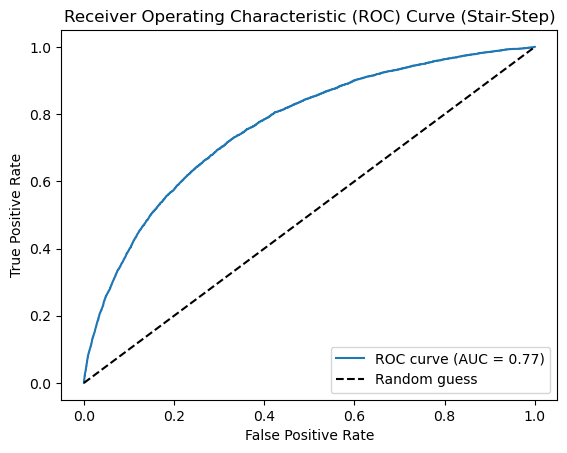

In [28]:
baseline_scores = complete_scoring(linear_model, X_train, y_train, X_val, y_val, cv=folds())

---
---
## 4.3 - Modèle `RandomForestClassifier` :

**Stratégie d'optimisation du modèle :**  
Avec GridSearchCV, réalisation d'une recherche des hyperparamètres optimaux suivants :
* **n_estimators** : [100, 200, 300, 400, 500]
* **max_depth** : [10, 20, 30]
* **min_samples_leaf** : [1, 5, 10]

In [17]:
# hyperparameters to optimize in GridSearchCV

param_rfc = {
    'random_forest__n_estimators': [100, 300, 500],
    'random_forest__max_depth': [10, 20, 30],
    'random_forest__min_samples_leaf': [1, 5, 10]
}

In [29]:
param_rfc = {
    'random_forest__n_estimators': [100, 500, 1000],
    'random_forest__max_depth': [20, 35, 50]
}

In [30]:
# Random Forest Classifier model pipeline 

rcf_model = Pipeline([
    ('preprocessor', preprocessor), 
    ('pca', PCA(n_components=0.95)),
    ('random_forest', RandomForestClassifier(random_state=42))
])

In [31]:
#grid_search(rcf_model, param_rfc, X_train, y_train, cv=folds())

In [ ]:
grid_search(rcf_model, param_rfc, X_train, y_train, cv=folds())

In [18]:
rcf_model = Pipeline([
    ('random_forest', RandomForestClassifier(n_estimators=2000, max_depth=10, random_state=42, n_jobs=8))
])

In [19]:
baseline_scores = complete_scoring(rcf_model, X_train, y_train, X_val, y_val, cv=folds())

Pipeline(steps=[('random_forest',
                 RandomForestClassifier(max_depth=10, n_estimators=2000,
                                        random_state=42))])

KeyboardInterrupt: 

## 4.4 - Modèle `LightGBM` :

## 4.5 - Modèle `XGBoost` :